In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Maximum likelihood estimation

## General machine learning through loss optimization
 
Usually a machine learning algorithm is formulated as an optimization process on a loss function. For instance, in linear regression

$$\hat{y}^{(i)} = Wx^{(i)}$$

with $x^{(i)}, W \in \mathbb{R}^n$ in a scenario with $n$-dimensional data (or $n-1$ considering adding an element vith value $1$ to $x$ to account for the bias). 

If we consider a MSE loss, we want to learn weights $W$ that minimize it

$$\underset{W}{\text{arg min}}\;\;\frac{1}{N}\sum_i \big(y^{(i)}-\hat{y}^{(i)}\big)^2$$

This is regularly referred to as the Ordinary Least Squares (OLS) solution.

Observe how we do this with `scipy.optimize` (we also did it previously with tensorflow optimizers)

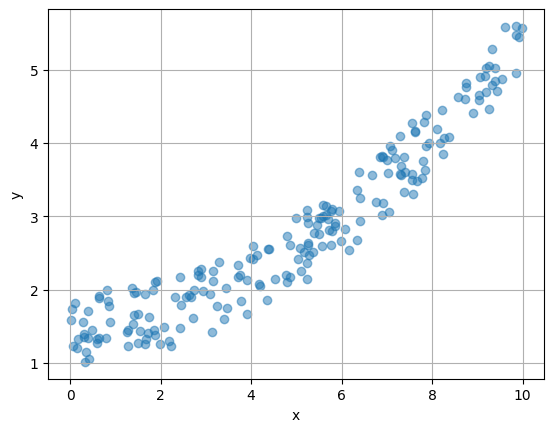

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

X = np.random.random(200)*10
y = (.2*X)**2 + 1 + np.random.random(len(X))
plt.scatter(X,y, alpha=.5)
plt.xlabel("x"); plt.ylabel("y"); plt.grid();

In [2]:
def linear_prediction(t, x):
    t0,t1 = t
    return t0 + t1*x

def J(t, x, y, prediction):
    return np.mean( (prediction(t,x)-y)**2)

r1 = minimize(lambda t: J(t, X, y, linear_prediction), np.random.random(size=2))


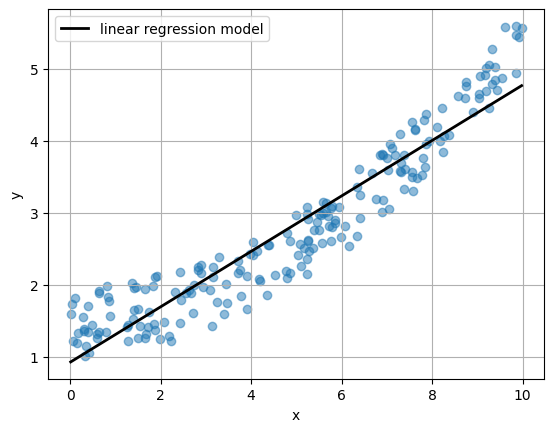

In [3]:
plt.scatter(X,y, alpha=.5)
plt.xlabel("x"); plt.ylabel("y"); plt.grid();
plt.xlabel("x"); plt.ylabel("y"); plt.grid();

xr = np.linspace(min(X), max(X), 100)
yr = linear_prediction(r1.x, xr)
plt.plot(xr, yr, color="black", lw=2, label="linear regression model")
plt.legend(), plt.grid();

## MLE approach

we know consider the same model but **from a probabilistic perspective**. Our variable es predicted through the same method (a linear regression with weights $W$), but we **explicitely** consider a error term $\varepsilon^{(i)}$ that we **ASSUME** it follows a normal distribution, centered on zero with unknown standard distribution $\sigma$.

$$y^{(i)} = Wx^{(i)} + \varepsilon^{(i)}$$

$$\varepsilon^{(i)} \sim \mathcal{N}(0, \sigma)$$

The consequence of this is that then $y^{(i)}$ becomes a random variable which can be seen as a certain operation that is done over the random variable $ \varepsilon^{(i)}$, thus producing a new random variable. Since we assume $\varepsilon^{(i)}$ has a normal distribution, then $y^{(i)}$ has a normal distribution, but centered around the prediction of the linear model

$$y^{(i)} \sim \mathcal{N}(Wx^{(i)}, \sigma)$$

This is, for every $x^{(i)}$ we have a distribution over the possible values $\hat{y}^{(i)}$ following the prediction of our linear model.

Following the PDF of a normal distribution, the probability of a certain $y^{(i)}$

$$P(y^{(i)}|x^{(i)}, W) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{y^{(i)} - Wx^{(i)}}{\sigma}\Big)^2}$$

Observe we are referring to $y^{(i)}$ and not $\hat{y}^{(i)}$, since now we have a distribution (under certain assumptions), and the $\hat{hat}$ notation refers to a point estimator. With the assumed distribution of $y^{(i)}$ we can do many things, among which, compute an estimator.


**Intuition**

What we want is to make the probability of our predictions as high as possible. This is

$$\underset{W}{\text{arg max}}\;\;P(Y|X,W)$$

where $Y$ is the vector containing all $y^{(i)}$ and $X$ the matrix containing all our $x^{(i)}$. And we obtain $P(Y|X,W)$ simply considering the joint probability of all data points, assuming they are independant among each other

$$\begin{align}
P(Y|X,W) =& \prod_i P(y^{(i)}|x^{(i)}, W)\\
         =& \prod_i \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{y^{(i)} - Wx^{(i)}}{\sigma}\Big)^2}
\end{align}$$

and, if we take the $\log$ everything is easier

$$\begin{align}
\log P(Y|X,W) =& \sum_i \log P(y^{(i)}|x^{(i)}, W)\\
         =& \sum_i \log \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{y^{(i)} - Wx^{(i)}}{\sigma}\Big)^2}\\
\end{align}$$


observe that we can maximize by minimizing the negative and we obtain the same result, **regardles $\sigma$**

In [4]:
def logprob(t, x, y, prediction, sigma=10):
    return np.sum(np.log(1e-15 + np.exp(-0.5*((prediction(t,x)-y)/sigma)**2)/(sigma*np.sqrt(2*np.pi))))

r1 = minimize(lambda t: -logprob(t, X, y, linear_prediction), np.random.random(size=2))

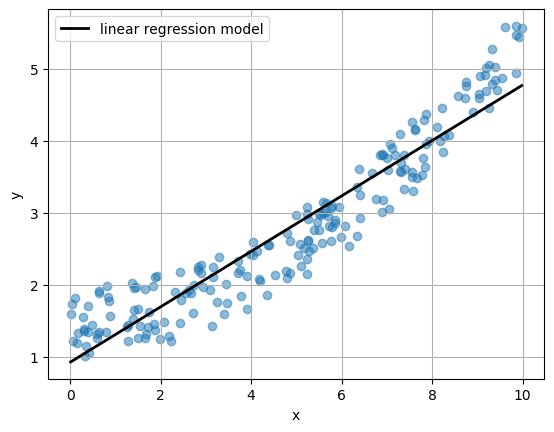

In [5]:
plt.scatter(X,y, alpha=.5)
plt.xlabel("x"); plt.ylabel("y"); plt.grid();
plt.xlabel("x"); plt.ylabel("y"); plt.grid();

xr = np.linspace(min(X), max(X), 100)
yr = linear_prediction(r1.x, xr)
plt.plot(xr, yr, color="black", lw=2, label="linear regression model")
plt.legend(), plt.grid();

In fact, observe that in this particular case (assuming normal noise $\varepsilon$) both approaches are mathematically equivalent

$$\begin{align}
\log P(Y|X,W) =& \sum_i \log P(y^{(i)}|x^{(i)}, W)\\
         =& \sum_i \log \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{y^{(i)} - Wx^{(i)}}{\sigma}\Big)^2}\\
         =& \sum_i -\frac{1}{2\sigma^2}\Big(y^{(i)} - Wx^{(i)}\Big)^2 - \log \sigma\sqrt{2\pi}\\
         =& \frac{1}{2\sigma^2} \sum_i -\Big(y^{(i)} - Wx^{(i)}\Big)^2 - C
\end{align}$$

$C$ being a constant that does not depend on the parameters we want to optimize

And finally:

$$\begin{align}
\underset{W}{\text{arg max}}\;\;P(Y|X,W) =& \;\;\underset{W}{\text{arg max}}\;\; \frac{1}{2\sigma^2} \sum_i -\Big(y^{(i)} - Wx^{(i)}\Big)^2 - C \\
=&\;\;\underset{W}{\text{arg max}}\;\; - \sum_i \Big(y^{(i)} - Wx^{(i)}\Big)^2 \\
=&\;\;\underset{W}{\text{arg min}}\;\; \sum_i \Big(y^{(i)} - Wx^{(i)}\Big)^2 \\
\end{align}
$$

which happens to be equivalent to the OLS above


### Estimating also $\sigma$

we can use the MLE approach to estimate the parameters we want. For instance, we could estimate sigma too. Note that we fit for a parameter squared, since $\sigma$ must be $>0$

In this case we want

$$\begin{align}
\underset{W,\sigma}{\text{arg max}}\;\;P(Y|X,W, \sigma) =& \;\;\underset{W, \sigma}{\text{arg max}}\;\; \frac{1}{2\sigma^2} \sum_i -\Big(y^{(i)} - Wx^{(i)}\Big)^2- \log \sigma\sqrt{2\pi} \\
\end{align}
$$


In [6]:
def logprob(t, x, y, prediction, sigma=10):
    return np.sum(np.log(1e-15 + np.exp(-0.5*((prediction(t,x)-y)/sigma)**2)/(sigma*np.sqrt(2*np.pi))))

r1 = minimize(lambda t: -logprob(t[:2], X, y, linear_prediction, sigma=t[-1]**2), np.random.random(size=3))

In [7]:
r1

      fun: 92.2637054790662
 hess_inv: array([[ 2.67610785e-03, -4.12027711e-04, -2.22786783e-06],
       [-4.12027711e-04,  8.66261977e-05, -5.23064883e-07],
       [-2.22786783e-06, -5.23064883e-07,  2.38812031e-04]])
      jac: array([ 0.00000000e+00, -9.53674316e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 16
     njev: 22
   status: 0
  success: True
        x: array([0.92582263, 0.38523908, 0.61952017])

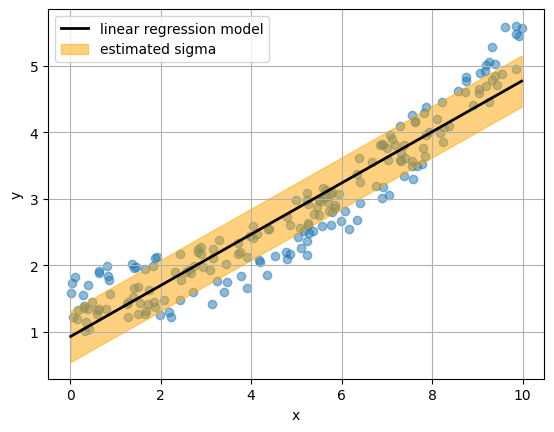

In [10]:
plt.scatter(X,y, alpha=.5)
plt.xlabel("x"); plt.ylabel("y"); plt.grid();
plt.xlabel("x"); plt.ylabel("y"); plt.grid();

r1_sigma = r1.x[2]**2
r1_t     = r1.x[:2]

xr = np.linspace(min(X), max(X), 100)
yr = linear_prediction(r1_t, xr)
plt.plot(xr, yr, color="black", lw=2, label="linear regression model")
plt.fill_between(xr, yr+r1_sigma, yr-r1_sigma, color="orange", alpha=.5, label="estimated sigma")
plt.legend(), plt.grid();

in a scenario with larger noise in data, sigma gets estimated larger as expected

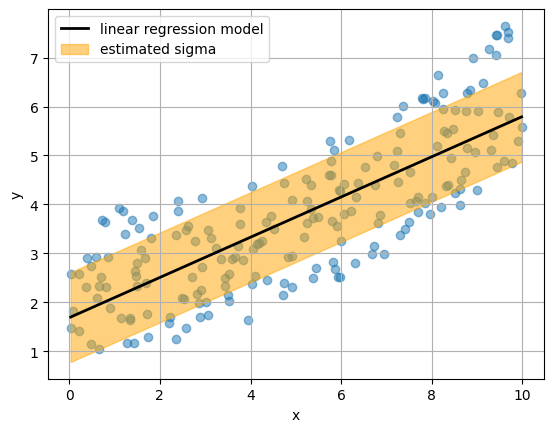

In [14]:
X = np.random.random(200)*10
y = (.2*X)**2 + 1 + np.random.random(len(X))*3

r1 = minimize(lambda t: -logprob(t[:2], X, y, linear_prediction, sigma=t[-1]**2), np.random.random(size=3))

plt.scatter(X,y, alpha=.5)
plt.xlabel("x"); plt.ylabel("y"); plt.grid();
plt.xlabel("x"); plt.ylabel("y"); plt.grid();

r1_sigma = r1.x[-1]**2
r1_t     = r1.x[:2]

xr = np.linspace(min(X), max(X), 100)
yr = linear_prediction(r1_t, xr)
plt.plot(xr, yr, color="black", lw=2, label="linear regression model")
plt.fill_between(xr, yr+r1_sigma, yr-r1_sigma, color="orange", alpha=.5, label="estimated sigma")
plt.legend(), plt.grid();

In [ ]:
ejercicio 1


def SparseMatrix(*args, **kwargs):
    
    
    class _SparseMatrix:
        
        def __init__(self, value, left=None, right=None):
            ... YOUR CODE HERE ...

        def T(self):
            ... YOUR CODE HERE ...
            
    return _SparseMatrix(*args, **kwargs)


ejercicio 2


def SparseMatrix2(*args, **kwargs):
    
    
    class _SparseMatrix2:
        
        def __init__(self, value, left=None, right=None):
            ... YOUR CODE HERE ...
            
        def to_dense(self):
            ... YOUR CODE HERE ...

        def T(self):
            ... YOUR CODE HERE ...
            
    return _SparseMatrix2(*args, **kwargs)



In [ ]:
def grader_ejercicio1(variables, functions, student):
    
    st_SparseMatrix = namespace['SparseMatrix']
    
    def teacher_SparseMatrix(*args, **kwargs):

        class _SparseMatrix:

            def __init__(self, value, left=None, right=None):
                ... YOUR CODE HERE ...

            def T(self):
                ... YOUR CODE HERE ...

        return _SparseMatrix(*args, **kwargs) 
    
    
    student_SparseMatrix_instance = st_SparseMatrix(askldakslj)
    teacher_SparseMatriix_instance = teacher_SparseMatrix(askldakslj)

    
    
    

In [ ]:
def grader_ejercicio2(variables, functions, student):
    
    st_SparseMatrix = namespace['SparseMatrix2']
